Data : https://www.kaggle.com/competitions/nlp-getting-started/overview

NoteBook (ML): https://www.kaggle.com/code/lokeshrth4617/nlp-getting-started-tutorial

Notebook2 (DL): https://www.kaggle.com/code/durgeshrao9993/nlp-with-tweets-eda-cleaning-bert-model

Each sample in the train and test set has the following information:

- The `text` of a tweet
- A `keyword` from that tweet (although this may be blank!)
- The `location` the tweet was sent from (may also be blank)

- The `target` variable in the train data indicates wether the tweet is related to a disaster or not( 1: disaster, 0: not a disaster)

# Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import string
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
train = pd.read_csv("./Data/train.csv")
test = pd.read_csv("./Data/test.csv")
display(train.head(5))
display(test.head(5))

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# EDA & preprocess

In [3]:
print(train.shape)
print(test.shape)

(7613, 5)
(3263, 4)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [6]:
# Check the frequency of each class of the target feature
train['target'].value_counts()/7613

0    0.57034
1    0.42966
Name: target, dtype: float64

In [7]:
train.text[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

## Missing values

In [8]:
train.isnull().sum()/4342

id          0.000000
keyword     0.014049
location    0.583372
text        0.000000
target      0.000000
dtype: float64

In [9]:
train['location'].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

Since more than half of this feature is `NaN` and ther existing ones do have a uniform type (for example USA, NewYork, and United States), we prefer to drop this feature. 

In [10]:
train['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [11]:
train['id'].value_counts()

1        1
7229     1
7250     1
7248     1
7247     1
        ..
3638     1
3637     1
3636     1
3635     1
10873    1
Name: id, Length: 7613, dtype: int64

since there is only one observation corresponding to each id, it seems the `id` column is not informative. So, we will drop it.

### Impute the `keyword` feature missing values (1)

In [12]:
data = train.copy()

In [13]:
imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='others')
data['keyword'] = imp.fit_transform(data['keyword'].values.reshape(-1, 1))


### Drop `location` and `id` features (2)

In [14]:
data = data.drop(['location', 'id'], axis= 1)
data

,keyword,text,target
0,others,Our Deeds are the Reason of this #earthquake M...,1
1,others,Forest fire near La Ronge Sask. Canada,1
2,others,All residents asked to 'shelter in place' are ...,1
3,others,"13,000 people receive #wildfires evacuation or...",1
4,others,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...
7608,others,Two giant cranes holding a bridge collapse int...,1
7609,others,@aria_ahrary @TheTawniest The out of control w...,1
7610,others,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,others,Police investigating after an e-bike collided ...,1


## Correct datatype (3)

In [15]:
type_new= {"target": "category"}
data= data.astype(type_new)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   keyword  7613 non-null   object  
 1   text     7613 non-null   object  
 2   target   7613 non-null   category
dtypes: category(1), object(2)
memory usage: 126.6+ KB


In [17]:
data.describe(include = 'all')

,keyword,text,target
count,7613,7613,7613
unique,222,7503,2
top,others,11-Year-Old Boy Charged With Manslaughter of T...,0
freq,61,10,4342


## Text preprocessing (4)

In [18]:

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

# Preprocess the data
def preprocess(text):
    #encoded_string = text.encode("ascii", "ignore") #remove non-ascii characters
    #text = encoded_string.decode()
    text = text.lower() #lower case
    text = re.sub(r"http\S+", "", text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text_clean = "  ".join(tokens)
    return text_clean

data['processed'] = data['text'].apply(preprocess)

#Remove punctuations
#data["text"]= data_clean["text"].apply(lambda x:  " ".join([x for x in word_tokenize(x)if x not in string.punctuation]))

data.head(20)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\solmaz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\solmaz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\solmaz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,keyword,text,target,processed
0,others,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,others,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,others,All residents asked to 'shelter in place' are ...,1,resident asked place notified officer eva...
3,others,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order ...
4,others,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfir...
5,others,#RockyFire Update => California Hwy. 20 closed...,1,rockyfire update california hwy closed di...
6,others,#flood #disaster Heavy rain causes flash flood...,1,flood disaster heavy rain cause flash fl...
7,others,I'm on top of the hill and I can see a fire in...,1,top hill see fire wood
8,others,There's an emergency evacuation happening now ...,1,emergency evacuation happening building ac...
9,others,I'm afraid that the tornado is coming to our a...,1,afraid tornado coming area


## Pos tagging

In [19]:
data['text'][7610]

'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ'

In [20]:
def preprocess_pos_tag(text):
    #text = text.lower() #lower case
    text = re.sub(r"http\S+", "", text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

In [21]:
# sample form class =1
print(pos_tag(preprocess_pos_tag(data['text'][7610])))

print(pos_tag(preprocess_pos_tag(data['text'][3])))

# a sample form class=0
print(pos_tag(preprocess_pos_tag(data['text'][16])))


[('UTC', 'NNP'), ('S', 'NNP'), ('Volcano', 'NNP'), ('Hawaii', 'NNP')]
[('people', 'NNS'), ('receive', 'VBP'), ('wildfire', 'NN'), ('evacuation', 'NN'), ('order', 'NN'), ('California', 'NNP')]
[('I', 'PRP'), ('love', 'VBP'), ('fruit', 'NN')]


In [22]:
nltk.help.upenn_tagset("NNP")
nltk.help.upenn_tagset("NN")

NNP: noun, proper, singular
    Motown Venneboerger Czestochwa Ranzer Conchita Trumplane Christos
    Oceanside Escobar Kreisler Sawyer Cougar Yvette Ervin ODI Darryl CTCA
    Shannon A.K.C. Meltex Liverpool ...
NN: noun, common, singular or mass
    common-carrier cabbage knuckle-duster Casino afghan shed thermostat
    investment slide humour falloff slick wind hyena override subhumanity
    machinist ...


It seems `text` from class = 1 contians "NNP" tags. Let's make sure:

In [23]:
data['no_nnp'] = data['text'].apply(lambda x: len([x for x in pos_tag(preprocess_pos_tag(x)) if x[1]== 'NNP']))
data

,keyword,text,target,processed,no_nnp
0,others,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u,5
1,others,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,5
2,others,All residents asked to 'shelter in place' are ...,1,resident asked place notified officer eva...,1
3,others,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order ...,1
4,others,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfir...,2
...,...,...,...,...,...
7608,others,Two giant cranes holding a bridge collapse int...,1,two giant crane holding bridge collapse ...,0
7609,others,@aria_ahrary @TheTawniest The out of control w...,1,thetawniest control wild fire california ...,3
7610,others,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,utc volcano hawaii,4
7611,others,Police investigating after an e-bike collided ...,1,police investigating collided car little ...,2


<Axes: xlabel='target', ylabel='no_nnp'>

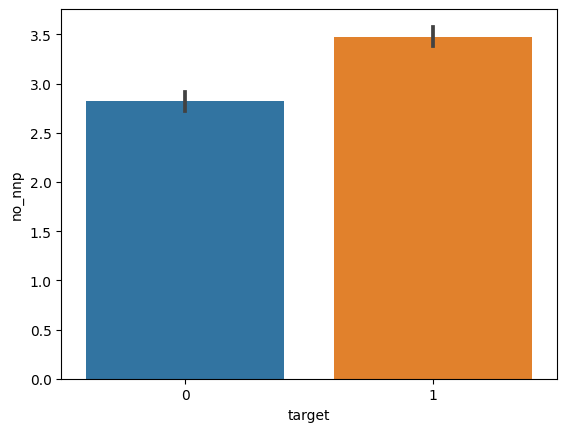

In [24]:
sns.barplot(data = data, x= 'target', y = 'no_nnp')

It seems there is a significant difference between number of number of NNP tags in class =1 and class =0. To make sure, let's conduct a hypothesis testing:

### Hypothesis testing: Two samples t-Test

In [25]:
from scipy import stats

df_groupby = data.groupby("target")
df_groupby_zero =df_groupby.get_group(0)
df_groupby_one =df_groupby.get_group(1)

Before conducting the t-test test, we need to check the equality of variances of the two groups. We do this using leven test:

In [26]:
stats.levene(df_groupby_one["no_nnp"], df_groupby_zero["no_nnp"], center= "median")

LeveneResult(statistic=1.0652662390010328, pvalue=0.3020499387445459)

The p-value of leven test in bigger than error type I (0.05) that we usually consider. This shows that we have to accept the null hypothesis and thus the variance of `no_nnp` within two classes in equal.

In [27]:
stats.ttest_ind(df_groupby_one["no_nnp"], df_groupby_zero["no_nnp"], equal_var=True)

Ttest_indResult(statistic=9.011922194146527, pvalue=2.524022444031781e-19)

As you see, the statistics of this test is about 9.01 and its p-value is a very small number near zero. Since we assume the type I error=0.05, and the p-value of the test is way less than that, we reject the null hypothesis. Thus, there is a statistically meaningful relationship between `no_nnp` and `target` features.

## Length analysis

In [28]:

data['word_count'] = data['text'].apply(lambda x : len(word_tokenize(x)))

data['sent_count'] = data['text'].apply(lambda x : len(sent_tokenize(x)))

In [29]:
data

,keyword,text,target,processed,no_nnp,word_count,sent_count
0,others,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u,5,14,1
1,others,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,5,8,2
2,others,All residents asked to 'shelter in place' are ...,1,resident asked place notified officer eva...,1,24,2
3,others,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order ...,1,9,1
4,others,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfir...,2,18,1
...,...,...,...,...,...,...,...
7608,others,Two giant cranes holding a bridge collapse int...,1,two giant crane holding bridge collapse ...,0,13,1
7609,others,@aria_ahrary @TheTawniest The out of control w...,1,thetawniest control wild fire california ...,3,24,2
7610,others,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,utc volcano hawaii,4,15,2
7611,others,Police investigating after an e-bike collided ...,1,police investigating collided car little ...,2,21,2


<Axes: xlabel='target', ylabel='sent_count'>

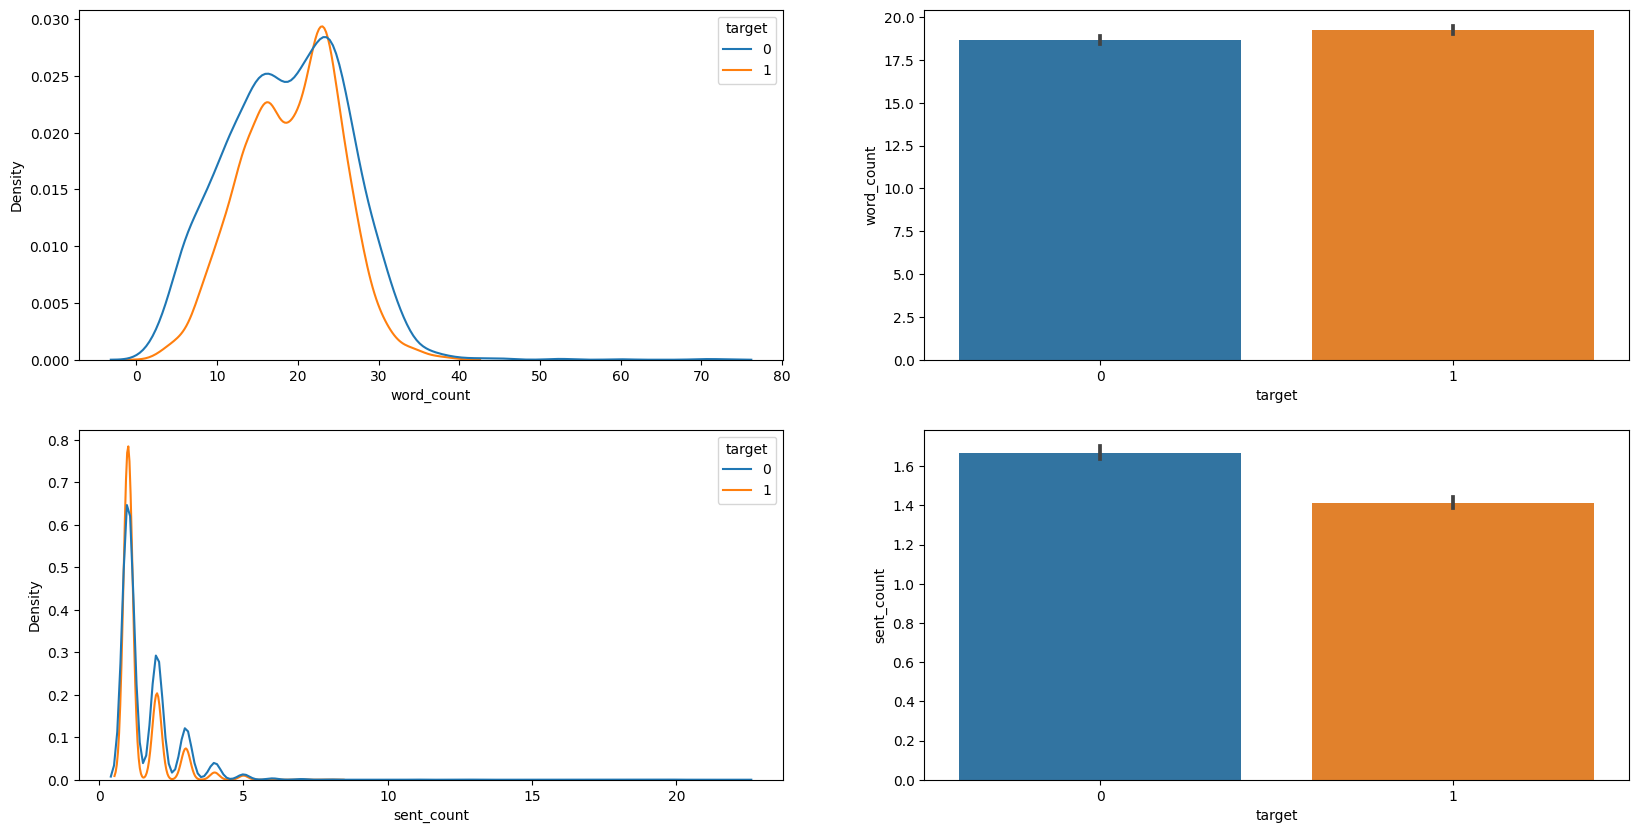

In [30]:
fig ,ax = plt.subplots(2,2, figsize= (20,10))

sns.kdeplot(data = data, x = 'word_count', hue = 'target', ax = ax[0,0] )
sns.barplot(data = data, x = 'target', y = 'word_count', estimator = 'mean',ax = ax[0,1]  )

sns.kdeplot(data = data, x = 'sent_count', hue = 'target', ax = ax[1,0] )
sns.barplot(data = data, x = 'target', y = 'sent_count', estimator = 'mean',ax = ax[1,1]  )


It seems there is meaningful diffrences between `sent_count` within two classes of `target` feature. let's check with hypothesis tesing:

In [31]:
df_groupby = data.groupby("target")
df_groupby_zero =df_groupby.get_group(0)
df_groupby_one =df_groupby.get_group(1) 

print(stats.levene(df_groupby_one["word_count"], df_groupby_zero["word_count"], center= "median"))
print(stats.levene(df_groupby_one["sent_count"], df_groupby_zero["sent_count"], center= "median"))


LeveneResult(statistic=155.9124256518784, pvalue=1.9647262631795638e-35)
LeveneResult(statistic=130.09473207300283, pvalue=6.826656706708698e-30)


Based on this Leven test, we reject the null hypothesis. Thus, the assumption of the equality of variances is violated and thus we set `equal_var = False` in the test. When we set the parameter `equal_var =False`, Welch’s t-test, which does not assume equal population variance, is performed. 

In [32]:
print(stats.ttest_ind(df_groupby_one["word_count"], df_groupby_zero["word_count"], equal_var=False))
print(stats.ttest_ind(df_groupby_one["word_count"], df_groupby_zero["word_count"], equal_var=False))

Ttest_indResult(statistic=3.867510581440696, pvalue=0.00011087304335724059)
Ttest_indResult(statistic=3.867510581440696, pvalue=0.00011087304335724059)


Based on the p-value, there is a meaningful relationship between the `target` feature and `word_count` and `setn_count` features.

### It seems the text within class 1 contians numbers. Let's check that:

In [33]:
data['exist_number'] = data['text'].apply(lambda x: 0 if re.search('[0-9]+', x)== None else 1 )

In [34]:
data

,keyword,text,target,processed,no_nnp,word_count,sent_count,exist_number
0,others,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u,5,14,1,0
1,others,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,5,8,2,0
2,others,All residents asked to 'shelter in place' are ...,1,resident asked place notified officer eva...,1,24,2,0
3,others,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order ...,1,9,1,1
4,others,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfir...,2,18,1,0
...,...,...,...,...,...,...,...,...
7608,others,Two giant cranes holding a bridge collapse int...,1,two giant crane holding bridge collapse ...,0,13,1,1
7609,others,@aria_ahrary @TheTawniest The out of control w...,1,thetawniest control wild fire california ...,3,24,2,0
7610,others,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,utc volcano hawaii,4,15,2,1
7611,others,Police investigating after an e-bike collided ...,1,police investigating collided car little ...,2,21,2,0


<Axes: xlabel='target', ylabel='count'>

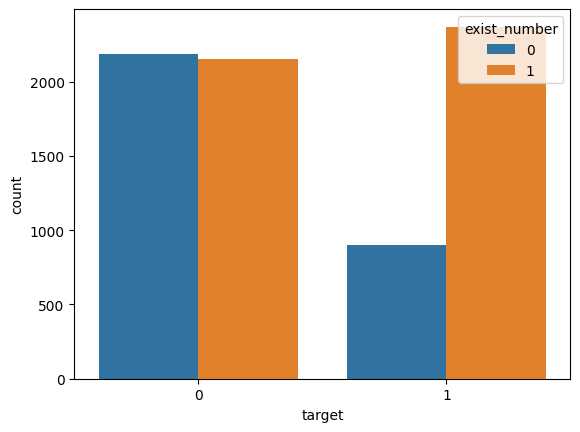

In [35]:
sns.countplot(data = data, x = 'target', hue = 'exist_number',)# estimator = 'count')

Based on the above plot, it seems there is relationship between `exist_number` and `target` features

In [36]:
from scipy.stats import chi2_contingency
#Create the cross-tabulation table without margins
cross_tab = pd.crosstab(data['exist_number'], data['target'])
#Perform the Chi-square indepndence test
chi2, p, dof, ex = chi2_contingency(cross_tab, correction=False)
print("Chi2-statistics:{}, p-value:{}, df :{}, \n ex:{}".format(chi2, p, dof, ex))

Chi2-statistics:403.0797882448397, p-value:1.1762775588529176e-89, df :1, 
 ex:[[1761.21056088 1326.78943912]
 [2580.78943912 1944.21056088]]


# Topic modeling

Latent Dirichlet Allocation (LDA) is a generative probabilistic model used in topic modeling, which is a subfield of natural language processing and machine learning. It aims to discover latent topics in a collection of documents by analyzing the co-occurrence patterns of words. LDA is based on the assumption that each document in a collection is a mixture of a small number of topics, and each topic is characterized by a distribution over words.

Here's a high-level overview of the LDA algorithm:

1. Determine the number of topics (K) you want to extract from the document collection.
2. Randomly assign each word in each document to one of the K topics.
3. Iterate over each word in each document and perform the following:

   a. For the current word, assume that all other topic assignments are correct.
 
   b. Update the topic assignment for the current word based on the likelihood of the word belonging to each topic, considering both the words in the current document and the words in all documents.

4. Repeat step 3 for a predetermined number of iterations or until convergence.

In [37]:
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim  
from gensim.models import LdaModel
import pyLDAvis.gensim_models as gensimvis


In [38]:
dictionary = corpora.Dictionary(data['processed'].apply(lambda x: word_tokenize(x)))
corpus = [dictionary.doc2bow(tweet) for tweet in data['processed'].apply(lambda x: word_tokenize(x))]

In [39]:
# Set the number of topics
num_topics = 6

# Train the LDA model
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)

# Print the topics
topics = lda_model.print_topics()
for topic in topics:
    print(topic)


(0, '0.016*"suicide" + 0.009*"bomber" + 0.007*"gt" + 0.007*"thunderstorm" + 0.006*"pm" + 0.006*"wreckage" + 0.006*"bomb" + 0.006*"trapped" + 0.006*"confirmed" + 0.006*"malaysia"')
(1, '0.015*"like" + 0.009*"amp" + 0.008*"get" + 0.008*"u" + 0.006*"time" + 0.006*"one" + 0.005*"wreck" + 0.005*"go" + 0.005*"got" + 0.005*"siren"')
(2, '0.013*"disaster" + 0.011*"storm" + 0.007*"one" + 0.007*"obama" + 0.006*"water" + 0.005*"flood" + 0.005*"violent" + 0.004*"life" + 0.004*"story" + 0.004*"school"')
(3, '0.020*"fire" + 0.007*"family" + 0.006*"via" + 0.006*"wild" + 0.005*"reddit" + 0.005*"legionnaire" + 0.005*"forest" + 0.005*"content" + 0.004*"thunder" + 0.004*"service"')
(4, '0.009*"weapon" + 0.008*"nuclear" + 0.006*"news" + 0.006*"hiroshima" + 0.005*"california" + 0.005*"hostage" + 0.005*"wildfire" + 0.005*"like" + 0.005*"still" + 0.005*"watch"')
(5, '0.014*"police" + 0.007*"wounded" + 0.006*"failure" + 0.006*"structural" + 0.005*"via" + 0.005*"traumatised" + 0.005*"officer" + 0.005*"black" +

In [40]:
# Prepare LDA visualization
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

# Visualize the topics
pyLDAvis.display(vis_data)


c:\Users\solmaz\anaconda3\envs\NLP\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [41]:
# Get the most probable topic for each tweet
most_probable_topics = []
for tweet_bow in corpus:
    topics = lda_model.get_document_topics(tweet_bow)
    most_probable_topic = max(topics, key=lambda x: x[1]) # Select topic with the highest probability
    most_probable_topics.append(most_probable_topic[0])

# Add most probable topic assignments to the original dataset
data['most_probable_topic'] = most_probable_topics

# Print the first 10 rows of the dataset with most probable topic assignments
data.head(10)


,keyword,text,target,processed,no_nnp,word_count,sent_count,exist_number,most_probable_topic
0,others,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u,5,14,1,0,1
1,others,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,5,8,2,0,1
2,others,All residents asked to 'shelter in place' are ...,1,resident asked place notified officer eva...,1,24,2,0,5
3,others,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order ...,1,9,1,1,3
4,others,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfir...,2,18,1,0,4
5,others,#RockyFire Update => California Hwy. 20 closed...,1,rockyfire update california hwy closed di...,7,23,2,1,4
6,others,#flood #disaster Heavy rain causes flash flood...,1,flood disaster heavy rain cause flash fl...,4,17,1,0,2
7,others,I'm on top of the hill and I can see a fire in...,1,top hill see fire wood,0,17,1,0,1
8,others,There's an emergency evacuation happening now ...,1,emergency evacuation happening building ac...,0,13,1,0,3
9,others,I'm afraid that the tornado is coming to our a...,1,afraid tornado coming area,0,12,1,0,4


In [42]:
from scipy.stats import chi2_contingency
#Create the cross-tabulation table without margins
cross_tab = pd.crosstab(data['most_probable_topic'], data['target'])
#Perform the Chi-square indepndence test
chi2, p, dof, ex = chi2_contingency(cross_tab, correction=False)
print("Chi2-statistics:{}, p-value:{}, df :{}, \n ex:{}".format(chi2, p, dof, ex))

Chi2-statistics:272.2733206897357, p-value:9.09290010985537e-57, df :5, 
 ex:[[ 600.56823854  452.43176146]
 [1104.1786418   831.8213582 ]
 [ 640.49205307  482.50794693]
 [ 669.57940365  504.42059635]
 [ 775.09234205  583.90765795]
 [ 552.0893209   415.9106791 ]]


## Preprocessing on Keyword

In [43]:
data['keyword_clean'] = data['keyword'].apply(preprocess)
data

,keyword,text,target,processed,no_nnp,word_count,sent_count,exist_number,most_probable_topic,keyword_clean
0,others,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u,5,14,1,0,1,others
1,others,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,5,8,2,0,1,others
2,others,All residents asked to 'shelter in place' are ...,1,resident asked place notified officer eva...,1,24,2,0,5,others
3,others,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order ...,1,9,1,1,3,others
4,others,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfir...,2,18,1,0,4,others
...,...,...,...,...,...,...,...,...,...,...
7608,others,Two giant cranes holding a bridge collapse int...,1,two giant crane holding bridge collapse ...,0,13,1,1,2,others
7609,others,@aria_ahrary @TheTawniest The out of control w...,1,thetawniest control wild fire california ...,3,24,2,0,3,others
7610,others,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,utc volcano hawaii,4,15,2,1,0,others
7611,others,Police investigating after an e-bike collided ...,1,police investigating collided car little ...,2,21,2,0,4,others


In [44]:
data['keyword_clean'].value_counts()

body          107
emergency     105
suicide        99
fatality       82
weapon         78
             ... 
rescue         22
epicentre      12
threat         11
inundation     10
radiation       9
Name: keyword_clean, Length: 202, dtype: int64

# Vectorization

We first perform the train-test split, then fit the vectorizers on the training data only, and transform both the training and test data using the trained vectorizers. This ensures that the text vectorization is performed separately on the training and test data, and that the test data is unseen during the pre-processing step, which is important for evaluating the performance of your model.

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

In [46]:
data.columns

Index(['keyword', 'text', 'target', 'processed', 'no_nnp', 'word_count',
       'sent_count', 'exist_number', 'most_probable_topic', 'keyword_clean'],
      dtype='object')

In [47]:
y = data['target']

X= data[['keyword_clean', 'processed', 'no_nnp', 'word_count', 'sent_count', 'exist_number', 'most_probable_topic']]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y ,test_size=0.25)

In [48]:
X_train

,keyword_clean,processed,no_nnp,word_count,sent_count,exist_number,most_probable_topic
68,accident,accident w nashvilletraffic traffic moving...,4,17,3,1,4
6225,smoke,miss josie cause wan na smoke splifs go...,1,16,2,0,1
4967,meltdown,ever since facebook mets meltdown padre ...,3,18,2,1,1
136,airplane,expert france begin examining airplane de...,4,23,1,0,0
5254,oil,syd traffic hazard oil spill bankstown s...,8,15,1,1,2
...,...,...,...,...,...,...,...
7607,others,stormchase violent record breaking el ren...,9,21,1,1,4
2045,danger,remainontop fettilootch slanglucci oppressi...,11,17,1,1,5
172,ambulance,twelve feared killed pakistani air ambula...,2,15,1,1,4
711,blazing,still know hour physical activity blazing...,0,20,1,1,4


In [49]:
X_train.reset_index(drop=True)

,keyword_clean,processed,no_nnp,word_count,sent_count,exist_number,most_probable_topic
0,accident,accident w nashvilletraffic traffic moving...,4,17,3,1,4
1,smoke,miss josie cause wan na smoke splifs go...,1,16,2,0,1
2,meltdown,ever since facebook mets meltdown padre ...,3,18,2,1,1
3,airplane,expert france begin examining airplane de...,4,23,1,0,0
4,oil,syd traffic hazard oil spill bankstown s...,8,15,1,1,2
...,...,...,...,...,...,...,...
5704,others,stormchase violent record breaking el ren...,9,21,1,1,4
5705,danger,remainontop fettilootch slanglucci oppressi...,11,17,1,1,5
5706,ambulance,twelve feared killed pakistani air ambula...,2,15,1,1,4
5707,blazing,still know hour physical activity blazing...,0,20,1,1,4


In [50]:
X_train['keyword_clean'].value_counts()

body          84
emergency     81
suicide       73
fatality      60
injury        56
              ..
arson         17
threat         9
inundation     7
radiation      7
epicentre      5
Name: keyword_clean, Length: 202, dtype: int64

## CountVectorizer

In [54]:

# Create a CountVectorizer object and fit it on the training data
cv = CountVectorizer()
cv.fit(X_train['processed'])

# Transform the training and test data using the fitted CountVectorizer
train_cv = cv.transform(X_train['processed'])
test_cv = cv.transform(X_test['processed'])



In [55]:
X_train_cv = pd.DataFrame(train_cv.toarray(), columns =cv.get_feature_names_out())

num_features = ['no_nnp', 'word_count', 'sent_count', 'exist_number', 'most_probable_topic']


for feature_name in num_features:
    X_train_cv[feature_name] = X_train.reset_index(drop=True)[feature_name]

In [204]:
X_train_cv

,aa,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aan,aannnnd,aar,aaronthefm,aashiqui,...,åç,åè,åê,åêfedex,ìñ,no_nnp,word_count,sent_count,exist_number,most_probable_topic
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,27,1,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,24,1,1,4
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,24,1,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,19,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5704,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,18,2,1,4
5705,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,14,3,0,1
5706,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5,20,2,1,5
5707,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,17,1,1,0


In [56]:
X_test_cv = pd.DataFrame(test_cv.toarray(), columns =cv.get_feature_names_out())


for feature_name in num_features:
    X_test_cv[feature_name] = X_test.reset_index(drop=True)[feature_name]

## Add `Keyword_clean` to train_cv and test_cv data using One-Hot encoding

In [59]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of OneHotEncoder
onehot_encoder = OneHotEncoder()

keyword_feature = X_train[['keyword_clean']]

# Perform one-hot encoding on the "nom_0" feature
onehot_encoded = onehot_encoder.fit_transform(keyword_feature)

# Convert the encoded features to a DataFrame
onehot_encoded_df = pd.DataFrame(onehot_encoded.toarray(), columns= onehot_encoder.get_feature_names_out(['keyword_clean']))

# Concatenate the original DataFrame with the one-hot encoded DataFrame
X_train_cv_keyword = pd.concat([X_train_cv, onehot_encoded_df], axis=1)

# Print the resulting DataFrame
X_train_cv_keyword

,aa,aaarrrgghhh,aan,aannnnd,aaronthefm,ab,aba,abandon,abandoned,abandonedpics,...,keyword_clean_weapon,keyword_clean_whirlwind,keyword_clean_wild,keyword_clean_wildfire,keyword_clean_windstorm,keyword_clean_wound,keyword_clean_wounded,keyword_clean_wreck,keyword_clean_wreckage,keyword_clean_wrecked
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5704,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5705,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5706,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5707,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
keyword_feature_test = X_test[['keyword_clean']]

# Perform one-hot encoding on the "nom_0" feature
onehot_encoded = onehot_encoder.transform(keyword_feature_test)

# Convert the encoded features to a DataFrame
onehot_encoded_df = pd.DataFrame(onehot_encoded.toarray(), columns= onehot_encoder.get_feature_names_out(['keyword_clean']))

# Concatenate the original DataFrame with the one-hot encoded DataFrame
X_test_cv_keyword = pd.concat([X_test_cv, onehot_encoded_df], axis=1)

# Print the resulting DataFrame
X_test_cv_keyword

,aa,aaarrrgghhh,aan,aannnnd,aaronthefm,ab,aba,abandon,abandoned,abandonedpics,...,keyword_clean_weapon,keyword_clean_whirlwind,keyword_clean_wild,keyword_clean_wildfire,keyword_clean_windstorm,keyword_clean_wound,keyword_clean_wounded,keyword_clean_wreck,keyword_clean_wreckage,keyword_clean_wrecked
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1900,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1901,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1902,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## TF-IDF

In [206]:
# Create a TfidfVectorizer object and fit it on the training data
tfidf = TfidfVectorizer(use_idf=True)
tfidf.fit(X_train['processed'])

# Transform the training and test data using the fitted TfidfVectorizer
train_tfidf = tfidf.transform(X_train['processed'])
test_tfidf = tfidf.transform(X_test['processed'])

In [207]:
num_features = ['no_nnp', 'word_count', 'sent_count', 'exist_number', 'most_probable_topic']


X_train_tfidf = pd.DataFrame(train_tfidf.toarray(), columns =tfidf.get_feature_names_out())
X_test_tfidf = pd.DataFrame(test_tfidf.toarray(), columns =tfidf.get_feature_names_out())


for feature_name in num_features:
    X_train_tfidf[feature_name] = X_train.reset_index(drop=True)[feature_name]
    X_test_tfidf[feature_name] = X_test.reset_index(drop=True)[feature_name]

In [208]:
X_train_tfidf

,aa,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aan,aannnnd,aar,aaronthefm,aashiqui,...,åç,åè,åê,åêfedex,ìñ,no_nnp,word_count,sent_count,exist_number,most_probable_topic
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3,27,1,0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,24,1,1,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,7,1,1,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,24,1,0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3,19,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,18,2,1,4
5705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,14,3,0,1
5706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5,20,2,1,5
5707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,17,1,1,0


## BOW

In [209]:

# Create a bag-of-words (BOW) vectorizer and fit it on the training data
bow = CountVectorizer(ngram_range=(1, 2), max_features=1000)
bow.fit(X_train['processed'])

# Transform the training and test data using the fitted BOW vectorizer
train_bow = bow.transform(X_train['processed'])
test_bow = bow.transform(X_test['processed'])


In [1]:
num_features = ['no_nnp', 'word_count', 'sent_count', 'exist_number', 'most_probable_topic']


X_train_bow = pd.DataFrame(train_bow.toarray(), columns =bow.get_feature_names_out())
X_test_bow = pd.DataFrame(test_bow.toarray(), columns =bow.get_feature_names_out())


for feature_name in num_features:
    X_train_bow[feature_name] = X_train.reset_index(drop=True)[feature_name]
    X_test_bow[feature_name] = X_test.reset_index(drop=True)[feature_name]

NameError: name 'pd' is not defined

# Model training

In [62]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, f1_score, recall_score, precision_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import VotingClassifier


In [61]:
# define the performance function for evaluation the performance of the models
def performance(model, vectorization_type):
    if vectorization_type == 'tfidf':
        X_train_local = X_train_tfidf
        X_test_local = X_test_tfidf
    elif vectorization_type == 'cv':
        X_train_local = X_train_cv
        X_test_local = X_test_cv
    elif vectorization_type == 'cv_keyword':
        X_train_local = X_train_cv_keyword
        X_test_local = X_test_cv_keyword       
    else:
        X_train_local = X_train_doc2vec
        X_test_local = X_test_doc2vec

        
    train_performance = []
    test_performance = []
    metrics_list = [accuracy_score,precision_score, recall_score, f1_score ]
    for m in metrics_list:
        train_performance.append(m(y_train,model.predict(X_train_local)))
        test_performance.append(m(y_test, model.predict(X_test_local)))

    
    performance_df = pd.DataFrame([train_performance,test_performance], columns=['accuracy', 'precision', 'recall', 'f1'], index= ['trian','test'])
    display(performance_df)

    #confusion matrix:

    #fig, ax = plt.subplots(1,2,figsize = (12,5))

    #cm_train_display = ConfusionMatrixDisplay.from_estimator(model, X_train_local, y_train, ax= ax[0])#display_labels = [False, True])
    #ax[0].set_title("Trian")

    #cm_test_display = ConfusionMatrixDisplay.from_estimator(model, X_test_local, y_test, ax = ax[1] )#display_labels = [False, True])
    #ax[1].set_title("Test")

    #cm_train_display.confusion_matrix
    #cm_test_display.confusion_matrix
    #plt.show()

In [212]:
preprocessor = ColumnTransformer( 
            [
            ('scalar', MinMaxScaler(), ['no_nnp', 'word_count', 'sent_count']),
            ('encoding', OneHotEncoder(), ['most_probable_topic'])
            ], remainder= 'passthrough'
)

## Check performance of all models on TF-IDF dataset:

In [63]:
model_list = [LogisticRegression(), RidgeClassifier(), LinearDiscriminantAnalysis(), RandomForestClassifier(),MultinomialNB(), xgb.XGBClassifier() , LinearSVC()]


In [214]:
for model in model_list:
    model.fit(X_train_tfidf, y_train)
    print(model)
    performance(model, 'tfidf')

c:\Users\solmaz\anaconda3\envs\NLP\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()


,accuracy,precision,recall,f1
trian,0.876861,0.934028,0.767631,0.842694
test,0.810399,0.833577,0.698044,0.759814


RidgeClassifier()


,accuracy,precision,recall,f1
trian,0.957961,0.974282,0.926620,0.949854
test,0.802521,0.800272,0.720049,0.758044


LinearDiscriminantAnalysis()


,accuracy,precision,recall,f1
trian,0.987563,0.985330,0.985732,0.985531
test,0.687500,0.620802,0.700489,0.658242


RandomForestClassifier()


,accuracy,precision,recall,f1
trian,0.990191,0.992602,0.984509,0.988539
test,0.795168,0.878092,0.607579,0.718208


MultinomialNB()


,accuracy,precision,recall,f1
trian,0.852514,0.948747,0.694252,0.801789
test,0.788866,0.882353,0.586797,0.704846


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


,accuracy,precision,recall,f1
trian,0.871957,0.949843,0.741133,0.832608
test,0.790441,0.818874,0.657702,0.729492


c:\Users\solmaz\anaconda3\envs\NLP\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()


,accuracy,precision,recall,f1
trian,0.965493,0.983290,0.935589,0.958847
test,0.799895,0.801379,0.710269,0.753078


## Check performance of all models on CV dataset:

In [65]:
for model in model_list:
    model.fit(X_train_cv, y_train)
    print(model)
    performance(model, 'cv')

c:\Users\solmaz\anaconda3\envs\NLP\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()


,accuracy,precision,recall,f1
trian,0.938343,0.965441,0.888300,0.925265
test,0.799895,0.813486,0.693154,0.748515


RidgeClassifier()


,accuracy,precision,recall,f1
trian,0.982659,0.993708,0.965756,0.979533
test,0.776261,0.767760,0.687042,0.725161


LinearDiscriminantAnalysis()


,accuracy,precision,recall,f1
trian,0.985286,0.986048,0.979617,0.982822
test,0.618697,0.546939,0.655257,0.596218


RandomForestClassifier()


,accuracy,precision,recall,f1
trian,0.989841,0.991383,0.984916,0.988139
test,0.780987,0.877589,0.569682,0.690882


MultinomialNB()


,accuracy,precision,recall,f1
trian,0.907514,0.932973,0.845495,0.887083
test,0.790966,0.800860,0.683374,0.737467


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


,accuracy,precision,recall,f1
trian,0.861797,0.929309,0.734203,0.820314
test,0.798319,0.838006,0.657702,0.736986


c:\Users\solmaz\anaconda3\envs\NLP\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()


,accuracy,precision,recall,f1
trian,0.985462,0.99211,0.973909,0.982925
test,0.774685,0.74904,0.715159,0.731707


## Handle overfitting

In [216]:
# Handlie overfitting in LDA model:
shrinkage = 0.5  # Set the shrinkage parameter for LDA
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage=shrinkage)
lda.fit(X_train_cv, y_train)
performance(lda, 'cv')

,accuracy,precision,recall,f1
trian,0.883167,0.923624,0.793722,0.853760
test,0.809349,0.834068,0.694377,0.757839


In [217]:
# Handlie overfitting in LDA model:
shrinkage = 0.75  # Set the shrinkage parameter for LDA
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage=shrinkage)
lda.fit(X_train_cv, y_train)
performance(lda, 'cv')

,accuracy,precision,recall,f1
trian,0.839026,0.858746,0.748471,0.799826
test,0.801471,0.806407,0.707824,0.753906


In [231]:
# Handle overfitting in Logestic Regression

# Instantiate a logistic regression model with L1 regularization
lr = LogisticRegression(penalty='l2', solver='liblinear', C=0.15) # C parameter is the inverse of regularization strength; smaller values specify stronger regularization.

# Train the model (assume X_train and y_train are your training data)
lr.fit(X_train_cv, y_train)

# Evaluate the model
performance(lr, 'cv')


,accuracy,precision,recall,f1
trian,0.880539,0.929229,0.781492,0.848981
test,0.814601,0.851740,0.688264,0.761325


In [235]:
# Handle over fitting for Random Forest


# Instantiate a Random Forest model
rf = RandomForestClassifier(n_estimators=300, min_samples_split=5, max_features='sqrt', min_samples_leaf=5, oob_score=True)

# Train the model (assume X_train and y_train are your training data)
rf.fit(X_train_cv, y_train)

performance(rf, 'cv')


,accuracy,precision,recall,f1
trian,0.80487,0.916615,0.600489,0.725616
test,0.77416,0.875969,0.552567,0.677661


## Enseble Learning 

In [236]:


# Define the models
model1 = LogisticRegression(penalty='l2', solver='liblinear', C=0.1)
model2 = xgb.XGBClassifier(
#    objective='binary:logistic',
#    max_depth=4,
#    n_estimators=100,
#    reg_lambda=1.0,  # L2 regularization (lambda)
#    reg_alpha=1.0   # L1 regularization (alpha)
)
model3 = LinearDiscriminantAnalysis(solver='eigen', shrinkage=.5)

# Combine the models into an ensemble
model_ens = VotingClassifier(estimators=[('lr', model1), ('xgb', model2), ('LDA', model3)], voting='hard')

# Train the ensemble model
model_ens.fit(X_train_cv, y_train)

# Evaluate on test data
performance(model_ens, 'cv')


,accuracy,precision,recall,f1
trian,0.874934,0.927273,0.769262,0.840909
test,0.814076,0.847305,0.691932,0.761777


In [237]:


# Define the models
model1 = LogisticRegression(penalty='l2', solver='liblinear', C=0.1)
model2 = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=4,
    n_estimators=100,
    reg_lambda=1.0,  # L2 regularization (lambda)
    reg_alpha=1.0   # L1 regularization (alpha)
)
model3 = LinearDiscriminantAnalysis(solver='eigen', shrinkage=.5)

# Combine the models into an ensemble
model_ens = VotingClassifier(estimators=[('lr', model1), ('xgb', model2), ('LDA', model3)], voting='hard')

# Train the ensemble model
model_ens.fit(X_train_cv, y_train)

# Evaluate on test data
performance(model_ens, 'cv')

,accuracy,precision,recall,f1
trian,0.871081,0.923951,0.762740,0.835641
test,0.813025,0.845808,0.690709,0.760431


## Check the performance on the X_train_cv_keyword

In [64]:
for model in model_list:
    model.fit(X_train_cv_keyword, y_train)
    print(model)
    performance(model, 'cv_keyword')

c:\Users\solmaz\anaconda3\envs\NLP\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()


,accuracy,precision,recall,f1
trian,0.938868,0.960999,0.894007,0.926294
test,0.797269,0.793478,0.713936,0.751609


RidgeClassifier()


,accuracy,precision,recall,f1
trian,0.983009,0.992887,0.967387,0.979971
test,0.779412,0.764628,0.702934,0.732484


LinearDiscriminantAnalysis()


,accuracy,precision,recall,f1
trian,0.988264,0.988534,0.984101,0.986313
test,0.644433,0.577729,0.640587,0.607536


RandomForestClassifier()


,accuracy,precision,recall,f1
trian,0.990016,0.993410,0.983286,0.988322
test,0.795168,0.876761,0.608802,0.718615


MultinomialNB()


,accuracy,precision,recall,f1
trian,0.899282,0.910044,0.849572,0.878769
test,0.791492,0.784076,0.710269,0.745350


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


,accuracy,precision,recall,f1
trian,0.860396,0.926365,0.733388,0.818658
test,0.805672,0.850000,0.665037,0.746228


c:\Users\solmaz\anaconda3\envs\NLP\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()


,accuracy,precision,recall,f1
trian,0.985987,0.993758,0.973502,0.983526
test,0.776261,0.748731,0.721271,0.734745


## Apply preprocessing steps in the `preprocessor` transformer

In [65]:
for model in model_list:
    pipe = Pipeline([('preprocessor', preprocessor),('clf', model)])
    pipe.fit(X_train_cv, y_train)
    print(model)
    performance(pipe, 'cv')

LogisticRegression()


,accuracy,precision,recall,f1
trian,0.954633,0.979039,0.913983,0.945393
test,0.794118,0.800847,0.693154,0.743119


RidgeClassifier()


,accuracy,precision,recall,f1
trian,0.984060,0.993729,0.969018,0.981218
test,0.777311,0.766216,0.693154,0.727856


LinearDiscriminantAnalysis()


,accuracy,precision,recall,f1
trian,0.987739,0.988120,0.983286,0.985697
test,0.639706,0.569767,0.658924,0.611111


RandomForestClassifier()


,accuracy,precision,recall,f1
trian,0.990016,0.994224,0.982470,0.988312
test,0.786765,0.867857,0.594132,0.705370


MultinomialNB()


,accuracy,precision,recall,f1
trian,0.912069,0.926915,0.863433,0.894048
test,0.806723,0.806540,0.723716,0.762887


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


,accuracy,precision,recall,f1
trian,0.857944,0.926715,0.726865,0.814713
test,0.797794,0.837754,0.656479,0.736121


LinearSVC()


,accuracy,precision,recall,f1
trian,0.987213,0.993776,0.976355,0.984989
test,0.777836,0.758170,0.709046,0.732786


# Doc2Vec

In [66]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [95]:
# Step 1: Text Representation with Doc2Vec
# Create TaggedDocument list
tagged_documents = []
for idx, text in enumerate(X_train['processed']):
     words = text.split()  # Tokenize your text appropriately
     tagged_document = TaggedDocument(words=words, tags=[idx])
     tagged_documents.append(tagged_document)

In [94]:
X_train

,keyword_clean,processed,no_nnp,word_count,sent_count,exist_number,most_probable_topic
7336,wildfire,idfire parker ridge fact sheet aug parke...,12,26,1,1,5
4462,hostage,hot specially modified land stadium rescu...,1,24,1,1,4
3766,fire,promise tax pancake rainbow dying fire,0,17,1,0,2
2380,derail,thejenmorillo gm pray attack enemy derail...,3,30,2,1,2
5120,nuclear,salem nuclear reactor shut electrical cir...,2,24,1,1,4
...,...,...,...,...,...,...,...
147,airplane,expert france begin examining airplane de...,5,22,1,0,0
5318,outbreak,outbreak legionnaire disease new york kil...,3,23,1,1,0
5089,nuclear,dalailama biggest nuclear disaster ever h...,1,12,1,0,4
5867,ruin,greedy bastard fullscreen way ruin creati...,5,16,2,1,3


In [97]:
tagged_documents[0]

[TaggedDocument(words=['idfire', 'parker', 'ridge', 'fact', 'sheet', 'aug', 'parker', 'ridge', 'wildfire', 'information', 'phone', 'email', 'pa'], tags=[0]),
 TaggedDocument(words=['hot', 'specially', 'modified', 'land', 'stadium', 'rescue', 'hostage', 'iran', 'prebreak', 'best'], tags=[1]),
 TaggedDocument(words=['promise', 'tax', 'pancake', 'rainbow', 'dying', 'fire'], tags=[2]),
 TaggedDocument(words=['thejenmorillo', 'gm', 'pray', 'attack', 'enemy', 'derail', 'ur', 'destiny', 'blocked', 'lord', 'amp', 'flood', 'ur', 'life', 'blessing'], tags=[3]),
 TaggedDocument(words=['salem', 'nuclear', 'reactor', 'shut', 'electrical', 'circuit', 'failure', 'pump', 'salem', 'nuclear', 'reactor', 'bee'], tags=[4]),
 TaggedDocument(words=['szmnextdoor', 'got', 'cute', 'lil', 'cliff', 'fall'], tags=[5]),
 TaggedDocument(words=['arian', 'foster', 'keep', 'promise', 'get', 'injured', 'every', 'yeat'], tags=[6]),
 TaggedDocument(words=['nigga', 'playing', 'thunderstorm', 'lorr', 'bless', 'em'], tags=[

In [146]:
# step 2: Initialize and train the Doc2Vec model
vector_size = 1000  # Set the dimensionality of the document vectors
window = 5  # Set the maximum distance between the current and predicted word
epochs = 20  # Set the number of training iterations
model = Doc2Vec(vector_size=vector_size, window=window, epochs=epochs)
model.build_vocab(tagged_documents)
model.train(tagged_documents, total_examples=model.corpus_count, epochs=model.epochs)

In [147]:
# Step 3: Feature Extraction and Model Training on Train and Test data
X_train_vectors = [model.infer_vector(text.split()) for text in X_train['processed']]
X_train_doc2vec = pd.DataFrame(X_train_vectors, columns=[f'doc_vec_{i}' for i in range(vector_size)])

num_features = ['no_nnp', 'word_count', 'sent_count', 'exist_number', 'most_probable_topic']

for feature_name in num_features:
    X_train_doc2vec[feature_name] = X_train.reset_index(drop=True)[feature_name]

In [119]:
X_train_doc2vec

,doc_vec_0,doc_vec_1,doc_vec_2,doc_vec_3,doc_vec_4,doc_vec_5,doc_vec_6,doc_vec_7,doc_vec_8,doc_vec_9,...,doc_vec_695,doc_vec_696,doc_vec_697,doc_vec_698,doc_vec_699,no_nnp,word_count,sent_count,exist_number,most_probable_topic
0,-0.010659,-0.001587,0.023368,0.018293,0.023747,-0.029110,-0.037970,-0.003706,0.006504,0.012576,...,-0.014765,-0.003425,-0.036519,0.023226,0.026539,12,26,1,1,5
1,-0.001245,-0.018589,-0.025458,0.004535,-0.014576,0.029408,0.022233,0.004776,0.001679,-0.013838,...,0.004606,0.009755,-0.002349,-0.018774,0.007771,1,24,1,1,4
2,-0.003758,-0.004682,-0.017371,0.008790,-0.002799,0.007296,0.007527,0.015466,0.007820,-0.003549,...,0.006758,-0.011150,-0.012816,-0.005556,0.006343,0,17,1,0,2
3,0.008430,0.004144,-0.017551,-0.009137,-0.005775,0.009945,0.009732,0.012472,0.001596,0.002803,...,0.011925,-0.006484,0.004436,-0.008468,-0.000044,3,30,2,1,2
4,0.027083,-0.002102,-0.043243,0.044493,0.010853,0.000751,-0.002865,0.014638,0.017017,0.000555,...,0.032942,-0.038910,-0.038703,0.020617,-0.017922,2,24,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5704,0.024335,0.018604,-0.022674,-0.006934,0.005023,0.010775,0.014038,0.008393,-0.030199,0.026082,...,-0.011970,0.000879,0.027394,-0.036958,0.006213,5,22,1,0,0
5705,0.007911,-0.015566,-0.008242,-0.009503,-0.022261,-0.051779,-0.002298,-0.010829,-0.003278,0.027446,...,0.000595,0.002751,0.010422,-0.021857,-0.017789,3,23,1,1,0
5706,0.029102,-0.000776,-0.023340,0.037083,0.022853,-0.010237,-0.011657,0.006546,0.011466,0.006736,...,0.017808,-0.028257,-0.033837,0.022555,-0.016046,1,12,1,0,4
5707,-0.002262,0.002374,-0.010987,0.012436,-0.011034,0.018702,0.004532,0.016384,0.008004,-0.008030,...,-0.007205,-0.008369,-0.005271,-0.005993,0.023697,5,16,2,1,3


In [143]:
X_train_doc2vec.describe()

,doc_vec_0,doc_vec_1,doc_vec_2,doc_vec_3,doc_vec_4,doc_vec_5,doc_vec_6,doc_vec_7,doc_vec_8,doc_vec_9,...,doc_vec_695,doc_vec_696,doc_vec_697,doc_vec_698,doc_vec_699,no_nnp,word_count,sent_count,exist_number,most_probable_topic
count,5709.000000,5709.000000,5709.000000,5709.000000,5709.000000,5709.000000,5709.000000,5709.000000,5709.000000,5709.000000,...,5709.000000,5709.000000,5709.000000,5709.000000,5709.000000,5709.000000,5709.000000,5709.000000,5709.000000,5709.000000
mean,0.000456,-0.001144,-0.012017,0.002767,-0.000621,0.009009,0.005880,0.008821,0.003878,-0.004576,...,0.003793,-0.006325,-0.004358,-0.004062,0.001165,3.086355,18.855141,1.550885,0.595025,2.372219
std,0.009005,0.005899,0.014729,0.012412,0.010876,0.018290,0.013108,0.009490,0.010884,0.011014,...,0.016426,0.011146,0.010705,0.015657,0.018043,3.161348,6.785393,0.927512,0.490930,1.640096
min,-0.079733,-0.057066,-0.105345,-0.074239,-0.091194,-0.122123,-0.089138,-0.028790,-0.089619,-0.081989,...,-0.073274,-0.067667,-0.060029,-0.069168,-0.126672,0.000000,1.000000,1.000000,0.000000,0.000000
25%,-0.002785,-0.002744,-0.019653,-0.001655,-0.004189,0.002074,0.001498,0.003711,0.001678,-0.009225,...,-0.002668,-0.011013,-0.008324,-0.010398,-0.002056,1.000000,14.000000,1.000000,0.000000,1.000000
50%,0.000222,-0.000930,-0.012624,0.003225,-0.000897,0.010605,0.006887,0.008585,0.005674,-0.005076,...,0.003601,-0.005572,-0.003814,-0.005786,0.002499,2.000000,19.000000,1.000000,1.000000,2.000000
75%,0.002644,0.001105,-0.005813,0.007634,0.002656,0.017914,0.011803,0.013815,0.009118,-0.000240,...,0.008914,-0.000704,0.000587,-0.000177,0.007897,5.000000,24.000000,2.000000,1.000000,4.000000
max,0.045089,0.032084,0.101991,0.064541,0.048132,0.113134,0.089388,0.126599,0.045595,0.068160,...,0.106022,0.044867,0.115196,0.105852,0.088268,22.000000,60.000000,13.000000,1.000000,5.000000


In [148]:
# prepare test data

X_test_vectors = [model.infer_vector(text.split()) for text in X_test['processed']]

X_test_doc2vec = pd.DataFrame(X_test_vectors, columns=[f'doc_vec_{i}' for i in range(vector_size)])

num_features = ['no_nnp', 'word_count', 'sent_count', 'exist_number', 'most_probable_topic']

for feature_name in num_features:
    X_test_doc2vec[feature_name] = X_test.reset_index(drop=True)[feature_name]


In [150]:
# Step 4: Train the ML model
model_list = [LogisticRegression(), RidgeClassifier(), LinearDiscriminantAnalysis(), RandomForestClassifier(), xgb.XGBClassifier() , LinearSVC()]

for model in model_list:
    model.fit(X_train_doc2vec, y_train)
    print(model)
    performance(model, 'doc2vec')

LogisticRegression()


c:\Users\solmaz\anaconda3\envs\NLP\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,accuracy,precision,recall,f1
trian,0.717814,0.721812,0.558500,0.629740
test,0.710084,0.715210,0.540342,0.615599


RidgeClassifier()


,accuracy,precision,recall,f1
trian,0.733754,0.751482,0.568284,0.647168
test,0.723214,0.738916,0.550122,0.630694


LinearDiscriminantAnalysis()


,accuracy,precision,recall,f1
trian,0.829042,0.837369,0.747248,0.789746
test,0.744223,0.723951,0.654034,0.687219


RandomForestClassifier()


,accuracy,precision,recall,f1
trian,1.000000,1.000000,1.000000,1.00000
test,0.759979,0.786054,0.606357,0.68461


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


,accuracy,precision,recall,f1
trian,1.000000,1.000000,1.000000,1.000000
test,0.760504,0.783699,0.611247,0.686813


LinearSVC()


c:\Users\solmaz\anaconda3\envs\NLP\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,accuracy,precision,recall,f1
trian,0.727098,0.845560,0.446392,0.584312
test,0.720063,0.848411,0.424205,0.565607


In [151]:
# Handle overfittin of xgboost
# Set your XGBoost hyperparameters
params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    #'learning_rate': 0.1,
    'n_estimators': 100,
    'lambda': 1.0,  # L2 regularization (lambda)
    'alpha': 1.0   # L1 regularization (alpha)
}

# Create an XGBoost classifier object
xgb_classifier = xgb.XGBClassifier(**params)

# Train the XGBoost classifier on the training data
xgb_classifier.fit(X_train_doc2vec, y_train)

performance(xgb_classifier, 'doc2vec')


,accuracy,precision,recall,f1
trian,0.985812,0.992934,0.973909,0.983330
test,0.753676,0.769706,0.608802,0.679863


In [144]:
for model in model_list:
    pipe = Pipeline([('scalar', StandardScaler()),('clf', model)])
    pipe.fit(X_train_doc2vec, y_train)
    print(model)
    
    performance(pipe, 'doc2vec')

c:\Users\solmaz\anaconda3\envs\NLP\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()


,accuracy,precision,recall,f1
trian,0.790331,0.795669,0.688952,0.738475
test,0.768908,0.777126,0.647922,0.706667


RidgeClassifier()


,accuracy,precision,recall,f1
trian,0.810825,0.826438,0.708520,0.762950
test,0.745273,0.734177,0.638142,0.682799


LinearDiscriminantAnalysis()


,accuracy,precision,recall,f1
trian,0.812051,0.822129,0.717896,0.766485
test,0.732143,0.708672,0.639364,0.672237


RandomForestClassifier()


,accuracy,precision,recall,f1
trian,1.000000,1.000000,1.000000,1.00000
test,0.750525,0.770932,0.596577,0.67264


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


,accuracy,precision,recall,f1
trian,1.000000,1.000000,1.000000,1.000000
test,0.765231,0.774815,0.639364,0.700603


LinearSVC()


c:\Users\solmaz\anaconda3\envs\NLP\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,accuracy,precision,recall,f1
trian,0.809424,0.817294,0.716673,0.763684
test,0.753676,0.740690,0.656479,0.696047


# Conclusion